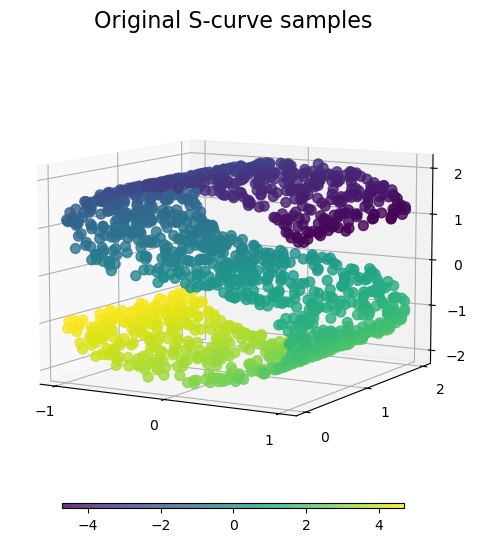

In [13]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import datasets, manifold

n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=0)

def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

plot_3d(S_points, S_color, "Original S-curve samples")

[   0    0    0 ... 1499 1499 1499] 150128
[1385 1251 1129 ... 1055  701  108] 150128
[0.6793 0.647  0.6541 ... 0.2571 0.2553 0.2056] 150128
float64
1500
90
150128
Spectral_fit
90


/home/coder/cuml/python/cuml/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


new
new1
new2
data size: 150128
col size: 150128
row size: 150128
n: 1500
k_graph.n_neighbors: 90
=[3,4,5,6];
=[2,0,2,1];
=[0,1,3,4];
=[3,4,5,6];
=[2,0,2,1];
=[0,1,3,4];
=[3,9,6];
seed 1234
lanczos iteration=[56.5476,82.9665,0];
0 2
lanczos iteration=[12.9431,73.7759,95.5868];
0 3
lanczos iteration=[6.09064,64.6486,79.8328];
0 4
lanczos iteration=[4.11462,35.6117,71.4129];
0 5
lanczos iteration=[2.4047,18.4425,63.9374];
0 6
lanczos iteration=[1.52393,13.736,48.9606];
0 7
lanczos iteration=[1.21744,12.0893,36.1927];
0 8
lanczos iteration=[1.06383,10.8106,24.4966];
0 9
lanczos iteration=[0.919606,8.47876,16.3257];
0 10
lanczos iteration=[0.793626,6.13306,13.9203];
0 11
lanczos iteration=[0.71702,5.01551,13.1356];
0 12
lanczos iteration=[0.675022,4.46759,12.6409];
0 13
lanczos iteration=[0.650205,4.1276,12.0566];
0 14
lanczos iteration=[0.63518,3.88531,11.0034];
0 15
lanczos iteration=[0.615344,3.44355,7.82957];
0 16
lanczos iteration=[0.595522,2.87904,6.04073];
0 17
lanczos iteration=[0.

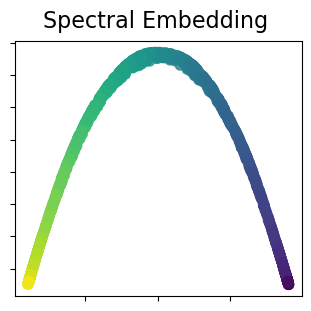

In [14]:
%reload_ext autoreload
%autoreload 2
import sklearn

from sklearn.manifold import SpectralEmbedding
from cuml.manifold import SpectralEmbedding as cuSpectralEmbedding
from sklearn.datasets import load_digits
from sklearn.manifold import trustworthiness
from cuml.manifold.umap import UMAP
from scipy.sparse import csr_matrix
import numpy as np

data_size = 1500
n_neighbors = 90

from sklearn.neighbors import kneighbors_graph
matrix1 = kneighbors_graph(
    S_points, n_neighbors, include_self=True, mode="distance",
)

matrix1 = matrix1 + matrix1.T
matrix1 = matrix1.tocoo()
print(matrix1.row, len(matrix1.row))
print(matrix1.col, len(matrix1.col))
print(matrix1.data, len(matrix1.data))
print(S_points.dtype)

s = cuSpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=1234, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))
Y = s.fit_transform(S_points)
print(Y)

csr_sym = csr_matrix((s.knn_dists, (s.knn_rows, s.knn_indices)), shape=(data_size, data_size))
csr_knn = csr_matrix((s.a_knn_dists, (s.a_knn_rows, s.a_knn_indices)), shape=(data_size, data_size))

trust = trustworthiness(S_points, Y, n_neighbors=n_neighbors)
print(trust)
print(Y)

plot_2d(Y, S_color, "Spectral Embedding")

In [1]:
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
matrix1 = kneighbors_graph(
    S_points, n_neighbors, include_self=True, mode="distance",
)
matrix1 = matrix1 + matrix1.T
matrix2 = csr_sym

np.set_printoptions(precision=4, suppress=True)

def printlen(matrix):
    print(matrix.row, len(matrix.row))
    print(matrix.col, len(matrix.col))
    print(matrix.data, len(matrix.data))
matrix2.eliminate_zeros()
# printlen(matrix2.tocoo())
# matrix1.sort_indices()
# matrix1 = matrix1.astype(np.float32)
# printlen(matrix1.tocoo())
printlen(matrix1.tocoo())
print(matrix1.toarray().shape)
print(matrix1.toarray().shape)

def printNorm(matrix1, matrix2):
    norm_diff = np.linalg.norm((matrix1 - matrix2).toarray())
    
    print("Frobenius norm difference:", norm_diff)
    
    # Compute element-wise difference
    diff_matrix = matrix1.toarray() - matrix2.toarray()
    print("max diff", np.max(diff_matrix), "min diff", np.min(diff_matrix))
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(diff_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title('Element-wise Difference between Matrices')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# printNorm(matrix1, matrix2)

NameError: name 'S_points' is not defined

In [25]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy import sparse
from sklearn.utils import check_array


def _set_diag(laplacian, value, norm_laplacian):
    """Set the diagonal of the laplacian matrix and convert it to a
    sparse format well suited for eigenvalue decomposition.

    Parameters
    ----------
    laplacian : {ndarray, sparse matrix}
        The graph laplacian.

    value : float
        The value of the diagonal.

    norm_laplacian : bool
        Whether the value of the diagonal should be changed or not.

    Returns
    -------
    laplacian : {array, sparse matrix}
        An array of matrix in a form that is well suited to fast
        eigenvalue decomposition, depending on the band width of the
        matrix.
    """
    n_nodes = laplacian.shape[0]
    # We need all entries in the diagonal to values
    if not sparse.issparse(laplacian):
        if norm_laplacian:
            laplacian.flat[:: n_nodes + 1] = value
    else:
        laplacian = laplacian.tocoo()
        if norm_laplacian:
            diag_idx = laplacian.row == laplacian.col
            laplacian.data[diag_idx] = value
        # If the matrix has a small number of diagonals (as in the
        # case of structured matrices coming from images), the
        # dia format might be best suited for matvec products:
        n_diags = np.unique(laplacian.row - laplacian.col).size
        if n_diags <= 7:
            # 3 or less outer diagonals on each side
            laplacian = laplacian.todia()
        else:
            # csr has the fastest matvec and is thus best suited to
            # arpack
            laplacian = laplacian.tocsr()
    return laplacian

matrix1 = kneighbors_graph(
    S_points, n_neighbors, include_self=True, mode="distance",
)
matrix1 = matrix1 + matrix1.T

spectral = SpectralEmbedding(
    n_components=2, n_neighbors=n_neighbors, random_state=1234, eigen_solver='lobpcg'
)

laplacian, dd = csgraph_laplacian(
    matrix1, normed=True, return_diag=True
)
# print(laplacian.tocoo())
# laplacian = check_array(
#     laplacian, dtype=[np.float64, np.float32], accept_sparse=True
# )
# laplacian = _set_diag(laplacian, 1, True)
laplacian = _set_diag(laplacian, 1, True)
print(laplacian.tocoo())
# laplacian *= -1

# laplacian = matrix1
spectral.affinity_matrix_ = matrix1
S_spectral = spectral.fit_transform(S_points)
print(S_spectral)

trust = trustworthiness(S_points, S_spectral, n_neighbors=n_neighbors)
print(trust)

plot_2d(S_spectral, S_color, "Spectral Embedding")
print(np.dot(S_spectral[:, 0], S_spectral[:, 1]))


matrix1 = matrix1.tocoo()
print(matrix1)
s = cuSpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=1234, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))
Y = s.fit_transform(S_points)

trust = trustworthiness(S_points, Y, n_neighbors=n_neighbors)
# Y = Y.T / dd
# Y = Y.T
print(Y)

plot_2d(Y, S_color, "Spectral Embedding")
print(trust)

print(np.dot(Y[:, 0], Y[:, 1]))

# [[ 0.0265 -0.0067  0.036   0.0197]
#  [ 0.0256 -0.0225  0.0073  0.0301]
#  [ 0.026  -0.0126  0.0288  0.0333]
#  ...
#  [ 0.028   0.0373 -0.0294  0.0184]
#  [ 0.025   0.0348 -0.0318  0.0273]
#  [ 0.0254  0.0261 -0.0014 -0.021 ]]


NameError: name 'S_points' is not defined

/home/coder/cuml/python/cuml/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Computing Spectral embedding...
<COOrdinate sparse matrix of dtype 'float64'
	with 144369 stored elements and shape (1083, 1083)>
  Coords	Values
  (0, 0)	6005.133202842793
  (0, 6)	-47.41307836451879
  (0, 12)	-26.095976701399778
  (0, 18)	-41.569219381653056
  (0, 22)	-43.497126341863094
  (0, 28)	-48.373546489791295
  (0, 29)	-27.184554438136374
  (0, 33)	-30.430248109405877
  (0, 48)	-30.512292604784715
  (0, 49)	-45.78209256903839
  (0, 78)	-37.04051835490427
  (0, 84)	-48.579831205964474
  (0, 96)	-46.51881339845203
  (0, 100)	-41.617304093369626
  (0, 106)	-26.210684844162312
  (0, 111)	-31.416556144810016
  (0, 122)	-25.39685019840059
  (0, 140)	-38.8329756778952
  (0, 154)	-24.698178070456937
  (0, 155)	-42.37924020083418
  (0, 161)	-38.05259518088089
  (0, 167)	-34.75629439396553
  (0, 173)	-45.16635916254486
  (0, 177)	-45.56314299957807
  (0, 183)	-44.13615298142782
  :	:
  (1082, 858)	-28.982753492378876
  (1082, 880)	-26.94438717061496
  (1082, 901)	-29.24038303442689
  (

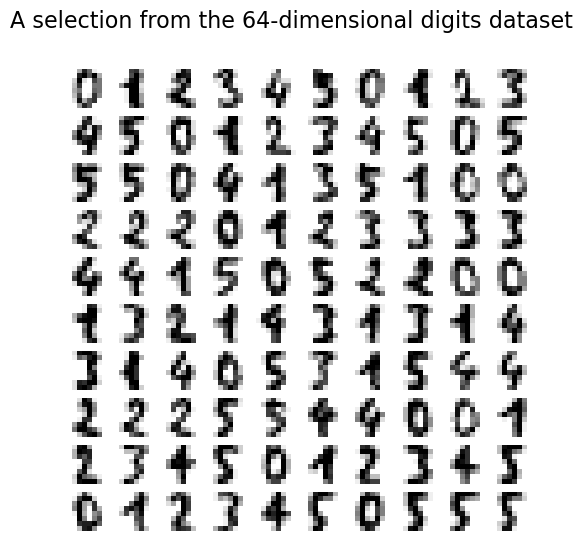

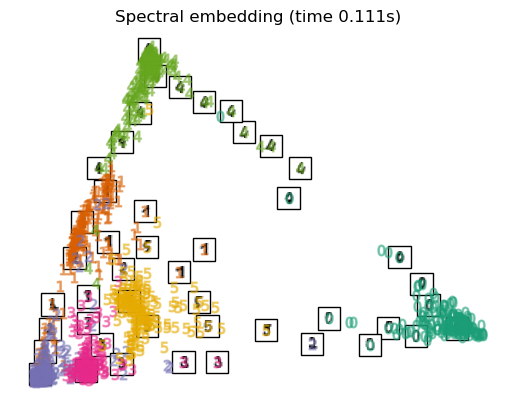

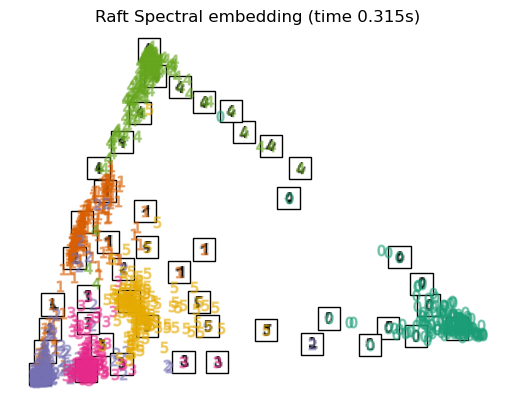

[[ 0.0679 -0.0144]
 [-0.0175  0.0173]
 [-0.0192  0.0065]
 ...
 [-0.0007  0.0611]
 [-0.0018  0.0654]
 [ 0.069  -0.0119]]
[[ 0.0679 -0.0144]
 [-0.0175  0.0173]
 [-0.0192  0.0065]
 ...
 [-0.0007  0.0611]
 [-0.0018  0.0654]
 [ 0.069  -0.0119]]
0.9267567037948565
0.9267567037948565


In [17]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")


from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    # "Random projection embedding": SparseRandomProjection(
    #     n_components=2, random_state=42
    # ),
    # "Truncated SVD embedding": TruncatedSVD(n_components=2),
    # "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
    #     n_components=2
    # ),
    # "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    # "Standard LLE embedding": LocallyLinearEmbedding(
    #     n_neighbors=n_neighbors, n_components=2, method="standard"
    # ),
    # "Modified LLE embedding": LocallyLinearEmbedding(
    #     n_neighbors=n_neighbors, n_components=2, method="modified"
    # ),
    # "Hessian LLE embedding": LocallyLinearEmbedding(
    #     n_neighbors=n_neighbors, n_components=2, method="hessian"
    # ),
    # "LTSA LLE embedding": LocallyLinearEmbedding(
    #     n_neighbors=n_neighbors, n_components=2, method="ltsa"
    # ),
    # "MDS embedding": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
    # "Random Trees embedding": make_pipeline(
    #     RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
    #     TruncatedSVD(n_components=2),
    # ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="lobpcg"
    ),
    # "t-SNE embedding": TSNE(
    #     n_components=2,
    #     max_iter=500,
    #     n_iter_without_progress=150,
    #     n_jobs=2,
    #     random_state=0,
    # ),
    # "NCA embedding": NeighborhoodComponentsAnalysis(
    #     n_components=2, init="pca", random_state=0
    # ),
}


from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy import sparse
from sklearn.utils import check_array


matrix1 = kneighbors_graph(
    X, max(int(X.shape[0] / 10), 1), include_self=True, mode="distance",
)
matrix1 = matrix1 + matrix1.T

laplacian, dd = csgraph_laplacian(
    matrix1, normed=True, return_diag=True
)
laplacian = _set_diag(laplacian, 1, True)
# laplacian *= -1

embeddings["Spectral embedding"].affinity_matrix_ = matrix1

# matrix1 = laplacian.tocoo()
matrix1 = matrix1.tocoo()
embeddings["Raft Spectral embedding"] = cuSpectralEmbedding(n_components=2, n_neighbors=max(int(X.shape[0] / 10), 1), random_state=0, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))


from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    if name ==   "Raft Spectral embedding":
        projections[name] = transformer.fit_transform(data)
        # projections[name] = projections[name].T / dd
        # projections[name] = projections[name].T
        # projections[name] *= - 1
    else:
        projections[name] = transformer.fit_transform(data, y)
    
    timing[name] = time() - start_time


for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)

plt.show()

print(projections["Spectral embedding"])
print(projections["Raft Spectral embedding"])
print(trustworthiness(X, projections["Spectral embedding"], n_neighbors=max(int(X.shape[0] / 10), 1)))
print(trustworthiness(X, projections["Raft Spectral embedding"], n_neighbors=max(int(X.shape[0] / 10), 1)))



In [2]:
def _set_diag(laplacian, value, norm_laplacian):
    """Set the diagonal of the laplacian matrix and convert it to a
    sparse format well suited for eigenvalue decomposition.

    Parameters
    ----------
    laplacian : {ndarray, sparse matrix}
        The graph laplacian.

    value : float
        The value of the diagonal.

    norm_laplacian : bool
        Whether the value of the diagonal should be changed or not.

    Returns
    -------
    laplacian : {array, sparse matrix}
        An array of matrix in a form that is well suited to fast
        eigenvalue decomposition, depending on the band width of the
        matrix.
    """
    n_nodes = laplacian.shape[0]
    # We need all entries in the diagonal to values
    if not sparse.issparse(laplacian):
        if norm_laplacian:
            laplacian.flat[:: n_nodes + 1] = value
    else:
        laplacian = laplacian.tocoo()
        if norm_laplacian:
            diag_idx = laplacian.row == laplacian.col
            laplacian.data[diag_idx] = value
        # If the matrix has a small number of diagonals (as in the
        # case of structured matrices coming from images), the
        # dia format might be best suited for matvec products:
        n_diags = np.unique(laplacian.row - laplacian.col).size
        if n_diags <= 7:
            # 3 or less outer diagonals on each side
            laplacian = laplacian.todia()
        else:
            # csr has the fastest matvec and is thus best suited to
            # arpack
            laplacian = laplacian.tocsr()
    return laplacian


In [24]:
%reload_ext autoreload
%autoreload 2
from sklearn.datasets import fetch_openml
import time as timey
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.manifold import SpectralEmbedding
from cuml.manifold import SpectralEmbedding as cuSpectralEmbedding
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix
from sklearn.manifold import trustworthiness
from scipy.sparse import random as sparse_random
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection
from scipy.sparse import csr_matrix, block_diag


# Generate a sparse dataset
n_samples = 2000
n_features = 50
n_informative = 10
n_redundant = 5
n_clusters_per_class = 2
density = 0.05
n_neighbors = 10
n_components = 2


# Create a dense dataset and convert it to sparse
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_clusters_per_class=n_clusters_per_class,
    random_state=42
)

print(X.shape)

X = sparse_random(n_samples, n_features, density=density, format='csr', random_state=42)
print(X.shape)
# X = X.toarray()
# print(np.count_nonzero(X)/ (X.shape[0] * X.shape[1]))



# # Load MNIST dataset
# mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# X, y = mnist.data, mnist.target.astype(int)
# X, y = X[:5000], y[:5000]


import matplotlib.pyplot as plt

def plot_mnist_examples(X, y, n_samples=10):
    fig, axs = plt.subplots(nrows=n_samples, ncols=n_samples, figsize=(10, 10))
    for idx, ax in enumerate(axs.ravel()):
        ax.imshow(X[idx].reshape((28, 28)), cmap=plt.cm.binary)
        ax.axis("off")
    _ = fig.suptitle("A selection from the MNIST dataset", fontsize=16)

# plot_mnist_examples(X, y)

from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler

def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in np.unique(y):
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit / 10),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    # for i in range(X.shape[0]):
    #     # plot every digit on the embedding
    #     # show an annotation box for a group of digits
    #     dist = np.sum((X[i] - shown_images) ** 2, 1)
    #     if np.min(dist) < 4e-3:
    #         # don't show points that are too close
    #         continue
    #     shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
    #     imagebox = offsetbox.AnnotationBbox(
    #         offsetbox.OffsetImage(X[i].reshape(28, 28), cmap=plt.cm.gray_r), X[i]
    #     )
    #     imagebox.set(zorder=1)
    #     ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

embeddings = {
    "Spectral embedding": SpectralEmbedding(
        n_components=n_components, random_state=0, eigen_solver="lobpcg"
    ),
}

from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy import sparse
from sklearn.utils import check_array

# matrix1 = kneighbors_graph(
#     X, n_neighbors, include_self=True, mode="distance",
# )
# matrix1 = matrix1 + matrix1.T
# print("Jupyter adjacency")
# print(matrix1.tocoo())

# laplacian, dd = csgraph_laplacian(
#     matrix1, normed=False, return_diag=True
# )
# print("Jupyter laplacian")
# print(laplacian.tocoo())
# laplacian = _set_diag(laplacian, 1, False)
# # laplacian *= -1
# print("Jupyter laplacian final")
# print(laplacian.tocoo())

# embeddings["Spectral embedding"].affinity_matrix_ = matrix1

# # matrix1 = laplacian.tocoo()
# matrix1 = matrix1.tocoo()
# # print(matrix1)
# embeddings["Raft Spectral embedding"] = cuSpectralEmbedding(n_components=n_components, n_neighbors=n_neighbors, random_state=0, rows=matrix1.row, cols=matrix1.col, vals=matrix1.data, nnz=len(matrix1.row))

# projections, timing = {}, {}
# for name, transformer in embeddings.items():
#     if name.startswith("Linear Discriminant Analysis"):
#         data = X.copy()
#         data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
#     else:
#         data = X

#     print(f"Computing {name}...")
#     start_time = time()
#     if name == "Raft Spectral embedding":
#         projections[name] = transformer.fit_transform(data.toarray())
#         print(projections[name])
#         # projections[name] = projections[name].T / dd
#         # projections[name] = projections[name].T
#         # projections[name] *= - 1
#     else:
#         projections[name] = transformer.fit_transform(data)
    
#     timing[name] = time() - start_time

# for name in timing:
#     title = f"{name} (time {timing[name]:.3f}s)"
#     # plot_embedding(projections[name], title)

# plt.show()


# timey.sleep(1)
# print(timing["Spectral embedding"])
# print(timing["Raft Spectral embedding"])
# # print(projections["Spectral embedding"])
# # print(projections["Raft Spectral embedding"])
# print(trustworthiness(X, projections["Spectral embedding"], n_neighbors=n_neighbors))
# print(trustworthiness(X, projections["Raft Spectral embedding"], n_neighbors=n_neighbors))


(2000, 50)
(2000, 50)
(2000, 50)


ValueError: dimension mismatch

In [18]:
print(dd)
print(len(dd))

laplacian_dd =[6005.13,7888.12,5659.48,7120.03,6212.13,5989,5890.44,5996.32,6560.62,8922.65,7695.39,6342.81,5063.45,5519.44,8750.41,5763.27,7210.38,6801.64,4842.84,7572.53,6702.15,7078.99,5182.51,8303.91,6516.96,7672.44,6411.92,6153.49,6010.04,5438.44,5029.79,4984.42,5061.74,4488.6,5580.25,5115.68,7989.51,7957.24,7868.92,7243.22,7111.88,7502.75,6886.53,8043.32,4465.21,7182.36,5369.61,5772.97,4236.39,5810.49,6123.45,6265.69,6474.45,8321.23,6978.73,6625.61,6753.97,6200.6,7957.16,9086.68,5733.7,6404.41,7423.79,4817.15,8258.56,6121.08,5715.61,7462.04,7150.57,7526.73,7446.12,5178.38,5547.42,6024.94,6913.58,6790.61,7866.38,4702.34,6343.24,5725.39,6539.21,5244.69,7339.08,5537.16,5560.95,5727.85,6738.46,6593.56,8468.74,6873.31,4410.21,5751.64,8771.14,5753.62,7762.92,5471,5377.67,6952.51,5473.92,5680.19,6238.73,6940.39,5740.87,6884.3,6626.61,5790.66,5666.35,4765.92,8652.19,8213.5,6898.24,4415.12,5357.36,9464.13,6830.76,6457.1,5272.99,7145.54,6384.78,6302.65,6615.86,6418.66,5547.8,5570.02,8151.53,10045.5,5274.99,4270.6,5562.3,6266.8,8172.49,5986.17,5635.17,5707.85,7450.35,6381.61,7550.22,5324.87,6169.08,6834.67,6049.53,5969.15,5507.08,6009.68,6078.72,6873.85,7167.19,5609,6270.67,9833.87,5872.72,6141.3,7081.88,8024.44,5705.15,5731.7,6261.82,7587.46,8657.87,6152.04,7491.19,6234.48,7698.89,7023.88,9695.13,7003.99,6193.3,7261.01,7780.52,6132.44,8365.05,6175.68,8778.37,4997.01,6898.08,7095.71,5476.31,5273.29,7389.51,6819.35,8404.55,7658.77,8163.73,5227.05,5927.3,5238.94,7118.94,7540.42,6099.15,6129.67,6090.98,6568.5,8816.54,7504.51,8117.66,6523.53,6049.44,6299.17,6809.8,7509.59,8293.61,6837.61,5331.25,6643.91,7126.04,7299.09,8509.85,6375.64,5832.44,6634.57,7434.1,6629.64,6984.46,7401.55,7249.5,6323.2,5928.46,5580.06,4810.13,6000.08,8040.9,6935.17,7912.19,6114.1,8042.41,6674.3,5420.8,6471.98,6732.16,5740.46,6338.6,7866.97,5731.6,7199.36,4675.2,5361.79,7690.62,7700.62,8021.23,6252.19,6120.29,7086.34,6761.97,6230.61,6521.44,7076.82,5777.53,6074.24,7459.21,5258.31,8942.74,7469.11,5347.52,6549.95,8461.25,4843.27,5722.22,10122.4,5422.35,7777.29,6220.49,7414.41,5925.69,6256.07,6694.15,7318.47,6324.57,5915.22,5053.08,6556.16,7268.56,6348.91,8658.29,7018.41,7827.59,7883.44,5414.75,6623.86,6567.61,7873.77,6926.06,8066.17,6112.23,4684.99,8477.88,6436.66,8153.05,8371.95,7556.61,6122.9,5817.18,7529.47,6168.62,7738.74,6027.72,6188.45,10444.1,4825.77,7541.31,5086.84,5306.43,7701.09,7584.24,8141.37,7866.93,7652.92,5044.62,6455.57,6223.79,8997.15,8135.41,6414.61,6850.13,4801.34,7092.49,6137.48,5512.19,6492.98,6224.74,5097.47,7352.28,6992.94,5328.02,5832.61,5599.14,5624.37,5600.1,6821.44,6183.77,5789.55,6380.71,6061.87,5719.79,6308.08,5079.11,6322.77,4992.32,4993.43,5929.34,5318.41,5575.1,4397.08,6257.02,6517.36,7050.45,5889.42,5084.75,7069.79,5556.62,5420.11,5655.13,5877.77,6449.18,5840.51,4934.81,6918.03,4967.99,5685.6,6074.83,6974.83,5379.44,5122.86,5514.99,5158.16,6059.66,5024.78,6077.1,5819.98,5644.44,6999.38,5064.73,5733.85,7864.19,7185.42,5796.35,4510.96,5425.63,6610.74,5006.16,6536,5602.9,6821.14,6759.59,7293.38,5910.34,5724.04,5595.09,5225.52,5438.51,6593.8,5750.12,7297.64,6309.96,8313,6932.09,8038.13,5208.27,6960.11,7383.94,6202.16,6398.57,6905.76,5628.32,6660,9038.96,7997.48,6834.14,6413.25,6588.38,6392.49,6490.12,6601.94,6261.15,9049.32,5991.08,7858.95,6644.26,6771.04,6446.07,5415.18,7336.74,7654.62,6039.17,6356.4,7796.28,6410.49,7903.81,7989.79,8218.73,7382.23,6712.76,7870.38,6830.97,6020.38,6850.22,6012.65,7358.49,7413.42,5662.95,6361,7843.35,7296.05,5220.41,6353.58,7831.82,6677.01,5842.86,6554.08,6576.85,5543.82,6059.54,6268.95,5523.08,6169.97,6809.25,7346.94,6657.2,6396.71,5113.85,5305.97,7582.91,7139.69,7706.63,5746.96,5546.71,5889.03,5502.86,6752.11,5069.41,5897.52,6092.88,5371.45,6037.8,6265.31,4990.63,9096.18,6139.67,7040.4,8679.13,5607.93,4497.16,7122.79,5673.42,7418.11,6028.52,5419.2,6019.06,5802.68,6255.16,6343.26,6268.72,7346.49,5853.03,7135.54,6274.61,7043.25,4394.18,4611.2,8940.23,5525.29,5771.79,5486.47,5317.15,8127.75,7841.76,7576.39,5542.08,6934.3,7787.52,7353.04,7380.68,6751.13,5364.06,6378.36,4961.67,5609.37,4809.65,5330.2,6551.12,8072.41,6161.05,6240.23,6236.99,7111.26,6762.47,7574.38,7130.08,6166.29,6887.56,6624.53,5396.43,6323.3,6407.88,8900.97,7253.08,5521.01,7333.21,8073,5324.98,5338.41,7596.6,6780.76,5579.52,6495.78,5802.93,5210.99,5338.91,6843.22,6456.73,6652.9,8008.51,4479.93,5725.28,5949.99,5826.9,5606.49,6082.86,5903.37,5175.84,6979.38,6499.08,6415.84,5808.16,6356.35,5793.01,6427.56,5611.91,5146.75,5859.21,5055.7,5384.93,5034.62,5138.42,6866.23,6219.24,5441.7,4914.93,7135.28,7401.19,7558,5224.41,5170.56,5761.05,6581.98,4947.99,6749.63,5274.6,6780.82,6211.8,6751.81,5062.96,4360.55,5101.54,5048.15,7356.47,5096.37,5047.08,5691.36,5011.59,5152.59,5421.4,5486.16,7305.01,5165.73,5403.14,5722.47,8286,4989.8,5146.71,5985.57,6638.98,5644.79,7008.35,6472.2,6994.4,6013.53,6073.85,5060.81,6241.6,4988.48,6229.05,7860.15,6709.38,8123.21,5450.84,7304.56,6047.14,8964.81,7430.66,6013.92,5200.99,6228.2,4158,6780.14,6161,6970.29,6509.69,6142.19,4746.78,7842.56,6927.61,7507.1,5194.67,5231.71,5982.78,8874.01,8166.72,6653.7,4318.99,4301.84,5927.5,5373.41,5797.41,6683.1,5728.27,6777.27,6432.63,6934.21,5803.07,5580.49,6518.28,7601.66,6152.75,6392.89,6555.33,5420.35,5186.86,4104.17,8185.11,6631.68,7088.33,7298.6,5640.12,6986.37,5909.07,6145.39,7085.85,5890.84,5900.68,6450.94,6406.09,6288.12,7623.96,6544.49,6755.18,6471.59,7548.69,5761.07,6821.2,6789.16,6409.84,7169.03,6806.32,7301.76,6285.63,5438.48,7373.1,7214.42,6363.58,6981.96,7460.25,5836.64,5335.04,6206.82,7242.85,8303.41,6025.85,5635.66,4889.56,7224.33,6519.77,6346.22,6673.81,5484.24,6611.48,7174.48,7164.21,6341.8,4383.76,5760.77,7243.52,5649.35,5950.7,6575.24,4006.83,4695.75,7486.79,8260.12,5866.94,4931.38,5517,6916.39,5856.49,6525.22,5861.25,5932.29,5667.12,7380.56,7341.27,6212.45,5539.02,6569.69,5952.28,6410.06,5122.91,5190.63,5989.43,6293.13,5630.94,7455.64,7216.08,7316.52,7028.28,5761.28,6814.56,7679.01,7053.51,5729.65,7192.98,4829.17,5533.58,5830.34,6070.17,5831.91,6762.77,7238.07,5781.28,5174.87,5890.28,5577.47,6200.29,7254.63,6412.21,5266.75,4033.66,5919.8,6160.2,6228.78,5331.51,5869.45,5701.42,7205.29,6030.19,7377.23,4766.51,6301.62,5649.71,5786.56,6727.44,6386.49,5051.12,7384.35,4664.56,7478.09,7887.39,7208.07,4558.84,5379.93,5511.38,6400.24,8164.5,5676.03,6652.94,6105.62,5458.38,5005.94,5441.61,5740.13,5444.37,5116.91,9107.35,8933.16,5635.87,6094.75,5499.17,6459.33,6604.73,6424.15,6337.09,5469.32,6520.32,4990.3,6180.31,5420.42,5953.12,8064.56,6600.82,7278.8,6799.51,7663.31,5566.51,6492.63,6284.89,5134.56,8413.63,6255.03,7698.19,6067.05,7884.32,6938.15,6363.13,7912.39,5842.61,6384.48,5297.99,6383.28,5822.02,5535.79,6436.65,7038.69,5925.67,4474.48,5651.42,5619.58,7591.65,8174.14,5378.14,6285.41,6491.76,5606.33,6011.13,7668.44,6476,6632.51,5146.69,5296.65,6927.75,7322.48,6532.03,5212.06,5078.92,6481.54,6961.33,6681.15,5521.3,8106.97,5637.15,8027.87,6227,5465.28,6120.42,6119.33,6370.47,7752.85,6594.52,4381.98,5396.26,6440.22,6680.96,7906.97,7070.19,7688.44,6157.06,7373.69,5397.25,6419.78,4802.76,6287.66,7079.17,6141.77,4288.82,6439.06,5442.55,8155.09,5761.22,5976.95,7690.73,7557,5451.3,8312.66,5610.89,6285.17,8799.96,5306.59,6698.03,4909.35,6076.2,8572.55,5668.84,5212.22,7407.42,5772.47,7065.8,7886.3,6511.34,7004.89,7776.45,6878.16,8175.42,6007.8,6110.89,7395.75,8402.58,9226.92,6364.11,6002.15,5574.12,7697.38,6089.12,7656.79,6611.93,6260.25,6144,6799.25,5951.97,7171.92,5797.71,7513.7,7531.88,6454.41,5654.48,6921.35,6576.82,6457.32,5235.08,5791.27,5379.24,6152.04,4628.8,4270.52,4797.25,6464.97,5363.65,4918.2,6874.32,6167.42,7904.27,6531.67,6580.87,6168.54,5708.53,5272.83,6641.12,5800.5,4907.76,10185.2,5760.92,5845.73,5852.24,7651.64,6497.4,5685.94,5689.54,8784.86,5710.2,7840.51,6233.22,6976.81,9565.3,5442.83,7027.35,5572.56,6574.92,9339.13,6002.84,6688.93,7543.84,5746.39,7501.75,5786.26,6649.32,7077.61,5431.67,6468.61,6924.55,6607.29,6454.97,7869.15,6218.67,5985.83,6386.99,5986.62,8104.7,8539.83,5626.46,7415.4,6642.33,4572.65,8523.61,7002.33,5666.65,7485.85,6972.29,6128.86,7903.66,7992.45,8017.19,6161.9,6709.56,7502.88,5463.38,7230.55,7143,5286.35,5445.79,5709.42,7134.29,6187.25,5044.52,7863.51,6400.63,6532.72,5269.17,6116.19,5609.94,6723.95,5737.66,6004.69,5732.42,5802.55,5660.89,4889.93,7009.36,5556.25,5339.87,6079.73,5830.55,7609.72,8129.07,5707.28,7136.54,6574.08,6969.64,7093.5,6062.57,6326.91,7377.95,6862.48,4628.45,5825.29,8083.59,6799.74,6424.79,6972.01,5846.38,7169.78,7403.41,6851.82,7403.78,6245.36,6363,7491.43,4696.35]
print(len(laplacian_dd))
print(np.asarray(laplacian_dd))

[77.4928 88.8151 75.2295 ... 79.7684 86.5531 68.5299]
1083
1083
[6005.13 7888.12 5659.48 ... 6363.   7491.43 4696.35]


In [19]:
import numpy as np
from scipy.sparse import csr_matrix, diags
from scipy.sparse.csgraph import laplacian as csgraph_laplacian

# Create a sample CSR matrix (adjacency matrix)
data = np.array([10, 1, 1, 3, 1, 2])
indices = np.array([1, 2, 0, 2, 0, 1])
indptr = np.array([0, 2, 4, 6])
adj_csr = csr_matrix((data, indices, indptr), shape=(3, 3))
adj_csr = adj_csr + adj_csr.T

print(adj_csr.todense())

# Compute the degree of each node
degrees = np.array(adj_csr.sum(axis=1)).flatten()

# Create the degree matrix (diagonal matrix with degrees)
degree_matrix = diags(degrees, offsets=0)

print(degree_matrix.todense())

# Compute the Laplacian matrix
laplacian_matrix = degree_matrix - adj_csr

# Print the Laplacian matrix in dense format
print(laplacian_matrix.todense())

laplacian, dd = csgraph_laplacian(
    adj_csr, normed=False, return_diag=True
)
# laplacian = _set_diag(laplacian, 1, True)
print(adj_csr.todense())
print(laplacian.todense())
print(dd)

laplacian = laplacian / dd
print(laplacian.todense())


[[ 0 11  2]
 [11  0  5]
 [ 2  5  0]]
[[13.  0.  0.]
 [ 0. 16.  0.]
 [ 0.  0.  7.]]
[[ 13. -11.  -2.]
 [-11.  16.  -5.]
 [ -2.  -5.   7.]]
[[ 0 11  2]
 [11  0  5]
 [ 2  5  0]]
[[ 13 -11  -2]
 [-11  16  -5]
 [ -2  -5   7]]
[13 16  7]
[[ 1.     -0.6875 -0.2857]
 [-0.8462  1.     -0.7143]
 [-0.1538 -0.3125  1.    ]]
